In [1]:
# %%
#### Imports ####
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [18]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier

In [3]:
import os

folder = r"/Users/rolandtuboly/Desktop/AIML/groupwork"
print(os.listdir(folder))

['.DS_Store', 'questions.txt', 'requirements.txt', 'README.md', '.gitignore', 'AIML_python_Roli_v2.ipynb', '.git', 'data', '.cache', 'src', 'AIML_2025_Gruop_Project.docx']


In [4]:
# %%
#### Load raw data ####


collision_raw = pd.read_csv(r"/Users/rolandtuboly/Desktop/AIML/groupwork/data/collision.csv")
casualty_raw = pd.read_csv(r"/Users/rolandtuboly/Desktop/AIML/groupwork/data/casualty.csv")
vehicle_raw = pd.read_csv(r"/Users/rolandtuboly/Desktop/AIML/groupwork/data/vehicle.csv")

# Number of rows and columns in our 3 csv-s
print("collision_raw:", collision_raw.shape)
print("casualty_raw:", casualty_raw.shape)
print("vehicle_raw:", vehicle_raw.shape)

/var/folders/ft/6z7djxg97d570tlrgw1kg5jm0000gn/T/ipykernel_12888/1325384673.py:5: DtypeWarning: Columns (0,2,39) have mixed types. Specify dtype option on import or set low_memory=False.
  collision_raw = pd.read_csv(r"/Users/rolandtuboly/Desktop/AIML/groupwork/data/collision.csv")


collision_raw: (100927, 44)
casualty_raw: (128272, 23)
vehicle_raw: (183514, 32)


/var/folders/ft/6z7djxg97d570tlrgw1kg5jm0000gn/T/ipykernel_12888/1325384673.py:7: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicle_raw = pd.read_csv(r"/Users/rolandtuboly/Desktop/AIML/groupwork/data/vehicle.csv")


In [5]:
# %%
#### We construct a binary target Y from collision_severity (where 1 = fatal, 2 = serious, 3 = slight) ####
y_collision = (collision_raw["collision_severity"] == 1).astype(int) # transform the boolean values to 0 and 1
collision_raw["target_fatal"] = y_collision # create a new column with the dependent variable

print("\nTarget distribution (0=non-fatal, 1=fatal):")
print(y_collision.value_counts(normalize=True)) # proportion of fatal and non-fatal collisions (~1.5% fatal)



Target distribution (0=non-fatal, 1=fatal):
collision_severity
0    0.985118
1    0.014882
Name: proportion, dtype: float64


In [6]:
# %%
#### Columns to DROP (IDs, constants, duplicates, leakage) ####

## From collision.csv
cols_to_drop_collision = [
    # IDs and constants (we keep collision_index for merging)
    "collision_year",
    "collision_ref_no",
    "location_easting_osgr",
    "location_northing_osgr",
    "local_authority_district",
    "local_authority_ons_district",
    "local_authority_highway",
    "local_authority_highway_current",
    # historic/duplicate coding
    "junction_detail_historic",
    "pedestrian_crossing_human_control_historic",
    "pedestrian_crossing_physical_facilities_historic",
    "carriageway_hazards_historic",
    # location has extremely many distinct values so we drop it
    "lsoa_of_accident_location",
    # other outcome variants (we already used collision_severity)
    "enhanced_severity_collision",
    "collision_injury_based",
    "collision_adjusted_severity_serious",
    "collision_adjusted_severity_slight",
    # we will use collision_severity only via target_fatal, so we drop that too
    "collision_severity",
]

## From casualty.csv
cols_to_drop_casualty = [
    # IDs and constants (we keep collision_index for merging)
    "collision_year",
    "collision_ref_no",
    "casualty_reference",
    # location has extremely many distinct values so we drop it
    "lsoa_of_casualty",
    # severity/outcome features
    "casualty_severity",
    "enhanced_casualty_severity",
    "casualty_injury_based",
    "casualty_adjusted_severity_serious",
    "casualty_adjusted_severity_slight",
    # age: we keep the banded version instead
    "age_of_casualty",
]

## From vehicle.csv
cols_to_drop_vehicle = [
    # IDs and constants (we keep collision_index for merging)
    "collision_year",
    "collision_ref_no",
    # historic/duplicate coding
    "vehicle_manoeuvre_historic",
    "vehicle_location_restricted_lane_historic",
    "journey_purpose_of_driver_historic",
    # location has extremely many distinct values so we drop it
    "lsoa_of_driver",
    # too many categories for a baseline model, we drop it
    "generic_make_model",
    # age: we keep the banded version instead
    "age_of_driver",
]

In [7]:
# %%
#### Create cleaned tables ####

collision_feat = collision_raw.drop(columns=cols_to_drop_collision)
casualty_feat = casualty_raw.drop(columns=cols_to_drop_casualty)
vehicle_feat = vehicle_raw.drop(columns=cols_to_drop_vehicle)

# Number of rows and columns in our 3 cleaned csv-s
print("collision_feat:", collision_feat.shape)
print("casualty_feat:", casualty_feat.shape)
print("vehicle_feat:", vehicle_feat.shape)

collision_feat: (100927, 27)
casualty_feat: (128272, 13)
vehicle_feat: (183514, 24)


In [22]:
# %%
#### Build collision-level modelling table ####
# Base unit: ONE ROW PER COLLISION (collision_index)
# We aggregate casualty and vehicle info to collision level first

# 1) Aggregate casualty-level info to collision level
casualty_agg = (
    casualty_feat
    .groupby("collision_index")
    .agg( # creating new, summarizing columns for the casualty aggregation
        n_pedestrians=("casualty_class", lambda s: (s == 3).sum()), # number of pedestrians
        mean_casualty_age_band=("age_band_of_casualty", "mean"), # average age band of casualties in the collision
        mean_casualty_imd=("casualty_imd_decile", "mean"), # average deprivation decile of casualties in the collision
        max_casualty_distance_band=("casualty_distance_banding", "max"), 
        # maximum distance band over casualties in the collision-"worst distance"
    )
    .reset_index() # turns collision_index back into a regular column instead of an index
)

print(casualty_agg.shape)

# 2) Aggregate vehicle-level info to collision level
vehicle_agg = (
    vehicle_feat
    .groupby("collision_index")
    .agg(
        mean_vehicle_age=("age_of_vehicle", "mean"), # average of age of vehicles involved in the casualties of the collision
        mean_engine_cc=("engine_capacity_cc", "mean"), # average of engine size of vehicles involved in the casualties of the collision
        share_left_hand_drive=("vehicle_left_hand_drive", lambda s: (s == 1).mean()), # fraction of vehicles that are left-hand drive
        share_escooter=("escooter_flag", lambda s: (s == 1).mean()), # share of vehicles that are e-scooters
    )
    .reset_index() # turns collision_index back into a regular column instead of an index
)

print(vehicle_agg.shape)

# 3) Merge everything to collision level
# Start from collision_feat (1 row per collision), then add casualty + vehicle aggregates.
model_df = (
    collision_feat
    .merge(casualty_agg, on="collision_index", how="left")
    .merge(vehicle_agg, on="collision_index", how="left")
)

print(model_df.shape)

(100927, 5)
(100927, 5)
(100927, 35)


In [9]:
# %%
#### We need to transform time: from HH:MM to useful and more interpretable numerical/categorical features ####

# Parse time column where the format is 'HH:MM'
model_df["time_parsed"] = pd.to_datetime(model_df["time"], format="%H:%M", errors="coerce")
model_df["hour_of_day"] = model_df["time_parsed"].dt.hour

def time_band(h): # function to define categories of time
    if pd.isna(h):
        return "unknown"
    h = int(h)
    if 0 <= h < 6:
        return "night" # 00:00–05:59
    elif 6 <= h < 10:
        return "morning_peak" # 06:00–09:59
    elif 10 <= h < 16:
        return "daytime" # 10:00–15:59
    elif 16 <= h < 20:
        return "evening_peak" # 16:00–19:59
    else:
        return "late_evening" # 20:00–23:59

model_df["time_band"] = model_df["hour_of_day"].apply(time_band)

In [10]:
# %%
#### We need to transform date too: from YYYY-MM-DD to numeric features ####

model_df["date_parsed"] = pd.to_datetime(model_df["date"], format="%d/%m/%Y", errors="coerce") # it is NaT if there is an error

model_df["day_of_week"] = model_df["date_parsed"].dt.dayofweek # 0=Monday, ..., 6=Sunday
model_df["month"] = model_df["date_parsed"].dt.month # 1-12
model_df["is_weekend"] = model_df["day_of_week"].isin([5, 6]).astype(int) # 1 if the day is Saturday/Sunday, 0 otherwise

# We drop raw minute-level time/date to avoid huge one-hot encodings later
model_df = model_df.drop(columns=["time", "time_parsed", "date", "date_parsed"])


In [11]:
# %%
### Converting to proper format ###
# 1) Columns you want as numeric
numeric_cols = [
    "number_of_vehicles",
    "number_of_casualties",
    "n_pedestrians",
    "mean_vehicle_age",
    "mean_engine_cc",
    "longitude",
    "latitude",
]

# 2) Convert these to numeric (invalid values -> NaN)
model_df[numeric_cols] = model_df[numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)

# 3) All remaining columns → categorical
cat_cols = model_df.columns.difference(numeric_cols)

model_df[cat_cols] = model_df[cat_cols].astype("category")

# (Optional) check:
print(model_df.dtypes)


collision_index                                category
longitude                                       float64
latitude                                        float64
police_force                                   category
number_of_vehicles                                int64
number_of_casualties                              int64
day_of_week                                    category
first_road_class                               category
first_road_number                              category
road_type                                      category
speed_limit                                    category
junction_detail                                category
junction_control                               category
second_road_class                              category
second_road_number                             category
pedestrian_crossing                            category
light_conditions                               category
weather_conditions                             c

In [12]:
# %%
#### Now we split into X (features) and y (target) ####

# Our target variable is collision-level fatal indicator
y = model_df["target_fatal"]

# Let's drop target and pure IDs from features
X = model_df.drop(
    columns=[
        "target_fatal",
        "collision_index",
        "vehicle_reference",
    ],
    errors="ignore",
) # errors="ignore": if columns wouldn't exist just ignore them

print("X:", X.shape)
print("y:", y.shape)

X: (100927, 35)
y: (100927,)


In [13]:
# %%
#### Train-test split ####

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=69
) # 80-20% split, stratify=y keeps the same class proportion (fatal/non-fatal) in train and test set

print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_test: ", X_test.shape, " y_test: ", y_test.shape)


X_train: (80741, 35)  y_train: (80741,)
X_test:  (20186, 35)  y_test:  (20186,)


In [14]:
### Preprocessing definitions ### 

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist() # list of numeric features
categorical_features = X.columns.difference(numeric_features).tolist() # everything else: list of categorical features

print(len(numeric_features)) # number of num features
print(len(categorical_features)) # number of cat features

# Helper function to force-cast data to strings
def to_string(x):
    return x.astype(str)

# 1. Numeric Pipeline: Impute Mean -> Scale
# Handles NaNs in numeric columns by filling with the mean
num_logit_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

# 2. Categorical Pipeline: Impute Constant -> OneHot
# Handles NaNs in categorical columns by filling with 'missing'
# This converts the offending 'float' NaNs into 'str' objects so OneHotEncoder doesn't crash
cat_logit_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('cast_to_str', FunctionTransformer(to_string, validate=False)),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

# Define the full column transformer
preprocess_logit = ColumnTransformer(
    transformers=[
        ("num", num_logit_pipe, numeric_features),
        ("cat", cat_logit_pipe, categorical_features),
    ]
)

# For decision tree (Standard Sklearn trees also fail on NaNs)
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy='mean'), numeric_features),
        ("cat", Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('cast_to_str', FunctionTransformer(to_string, validate=False)),
            ('encoder', OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ]
)

7
28


In [15]:
# %%
#### We chose a LASSO Logistic Regression (L1) + 5-fold cross-validation ####
# LASSO to zero out unnecessary features instead of ridge based on our discussion with prof. Wachs

# Lasso = L1 penalty
logit = LogisticRegression(
    penalty="l1", # lasso: can drive some coefficients exactly to zero
    solver="liblinear", # supports L1 + class_weight for binary classification
    max_iter=2000, # allow enough iterations to converge
    class_weight="balanced", # reweights classes inversely to their frequency; important for rare fatal events
 )

logit_pipeline = Pipeline( # treat preprocessing + classifier as one model
    steps=[
        ("preprocess", preprocess_logit), # StandardScaler + OneHotEncoder (defined earlier)
        ("clf", logit), # classifier
    ]
) 

# Tune regularization strength C (smaller C means stronger regularization)
logit_param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1.0],  # inverse of regularization strength (smaller C -> stronger regularization, sparser model)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)  # cross-validation setup

logit_grid = GridSearchCV(
    estimator=logit_pipeline, # the full pipeline we are tuning
    param_grid=logit_param_grid, # dictionary of hyperparameters to search over
    scoring="recall", # instead of accuracy, we want the fatals to be predicted accurately
    n_jobs=-1, # all CPU
    cv=cv, # StratifiedKFold from earlier
    verbose=1,
)

print("\n=== Fitting Lasso (L1) Logistic Regression with CV (collision-level) ===")
logit_grid.fit(X_train, y_train)  # try each C and run the 5-fold CV, compute roc_auc and pick the best

print("\nBest lasso-logit params:", logit_grid.best_params_)
print("Best CV recall (lasso-logit):", logit_grid.best_score_)

best_logit = logit_grid.best_estimator_ # final chosen logistic model
y_pred_logit = best_logit.predict(X_test) # vector of hard class labels (fatal or non-fatal)
y_proba_logit = best_logit.predict_proba(X_test)[:, 1] # compute metrics (e.g. recall)

print("\n=== Lasso Logistic Regression: Test performance ===")
print(classification_report(y_test, y_pred_logit, digits=3))
print("Test recall (lasso-logit):", recall_score(y_test, y_pred_logit))


=== Fitting Lasso (L1) Logistic Regression with CV (collision-level) ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best lasso-logit params: {'clf__C': 0.01}
Best CV recall (lasso-logit): 0.7920228215767635

=== Lasso Logistic Regression: Test performance ===
              precision    recall  f1-score   support

           0      0.995     0.709     0.828     19886
           1      0.039     0.777     0.074       300

    accuracy                          0.710     20186
   macro avg      0.517     0.743     0.451     20186
weighted avg      0.981     0.710     0.817     20186

Test recall (lasso-logit): 0.7766666666666666


Exception ignored in: <function ResourceTracker.__del__ at 0x110265bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103de9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103ee9bc0>
Traceback (most recent call last

In [16]:
# %%
#### Random Forest + CV ####

rf = RandomForestClassifier(
    random_state=68,
    class_weight="balanced_subsample", # rebalance classes when building each tree; important because fatals are rare
    n_jobs=-1, # all CPU
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_tree),
        ("clf", rf),
    ]
)

rf_param_grid = {
    "clf__n_estimators": [200], # no. of trees in the forest, we fix it at 200
    # (decent-size forest, usually stable, without wasting too much computational power)
    "clf__max_depth": [10, 20, 30], # maximum depth each individual tree can grow to
    # if smaller, strongly regularized -> less overfitting
    "clf__min_samples_leaf": [1, 5, 10], # minimum number of samples allowed in a leaf node
    # if smaller, bigger flexibility, highest overfitting risk
}  # hyperparameters chosen based on previous results and computational limits

rf_grid = GridSearchCV(
    estimator=rf_pipeline, # the full pipeline we are tuning
    param_grid=rf_param_grid, # dictionary of hyperparameters to search over
    scoring="recall", # instead of accuracy, it is better for our data (imbalanced)
    n_jobs=-1, # all CPU
    cv=cv, # StratifiedKFold from earlier
    verbose=1,
)

print("\n=== Fitting Random Forest with CV (collision-level) ===")
rf_grid.fit(X_train, y_train) # try each hyperparameter and run the 5-fold CV, compute roc_auc and pick the best

print("\nBest random forest params:", rf_grid.best_params_)
print("Best CV recall (random forest):", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_ # final chosen random forest model
y_pred_rf = best_rf.predict(X_test) # vector of hard class labels (fatal or non-fatal)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1] # compute metrics (e.g. ROC AUC)

print("\n=== Random Forest: Test performance ===")
print(classification_report(y_test, y_pred_rf, digits=3))
print("Test recall (RF):", recall_score(y_test, y_pred_rf))


=== Fitting Random Forest with CV (collision-level) ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best random forest params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 200}
Best CV recall (random forest): 0.674692254495159

=== Random Forest: Test performance ===
              precision    recall  f1-score   support

           0      0.993     0.764     0.863     19886
           1      0.039     0.640     0.074       300

    accuracy                          0.762     20186
   macro avg      0.516     0.702     0.469     20186
weighted avg      0.979     0.762     0.852     20186

Test recall (RF): 0.64



=== Feature importances (Aggregated by original variable) ===
                               original_feature  importance
2   did_police_officer_attend_scene_of_accident    0.144857
30                                  speed_limit    0.079673
33                          urban_or_rural_area    0.075747
7                              junction_control    0.054841
22                                 police_force    0.046016
4                             first_road_number    0.038482
21                          pedestrian_crossing    0.035898
8                               junction_detail    0.033144
13                       mean_casualty_age_band    0.033136
32                              trunk_road_flag    0.030538
28                        share_left_hand_drive    0.027364
26                           second_road_number    0.027333
10                             light_conditions    0.027214
25                            second_road_class    0.026001
19                         number_of_

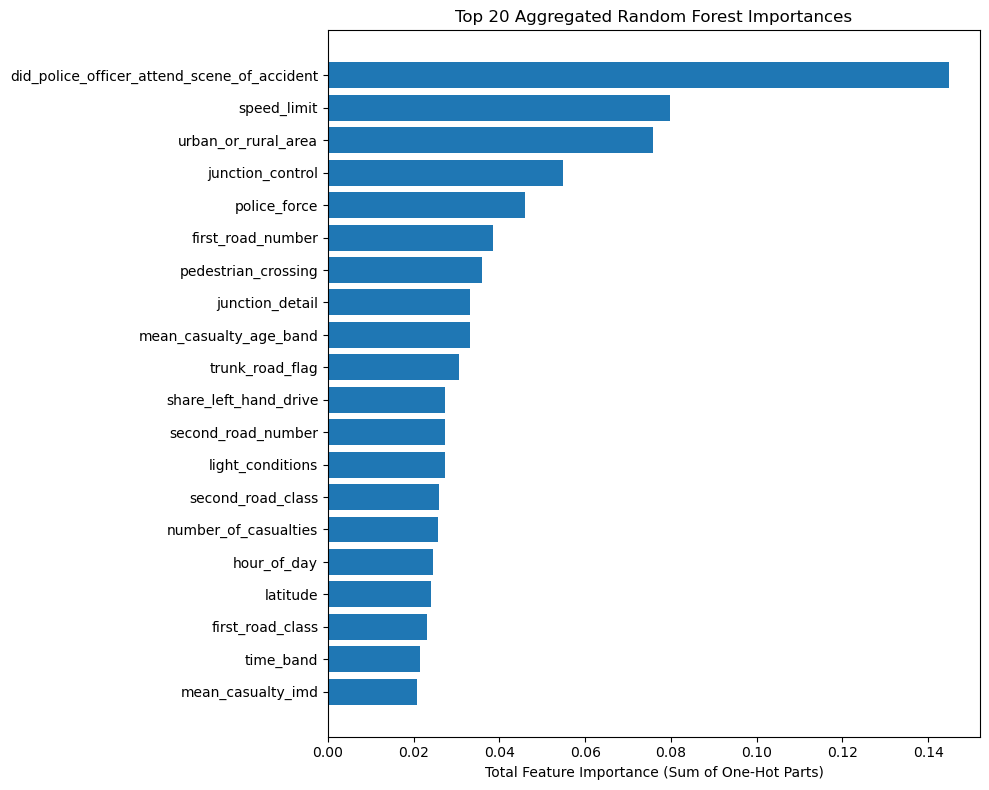


Breakdown of top feature 'did_police_officer_attend_scene_of_accident':
                                  encoded_feature  importance  \
28  did_police_officer_attend_scene_of_accident_1    0.068631   
30  did_police_officer_attend_scene_of_accident_3    0.050158   
29  did_police_officer_attend_scene_of_accident_2    0.026068   

                               original_feature  
28  did_police_officer_attend_scene_of_accident  
30  did_police_officer_attend_scene_of_accident  
29  did_police_officer_attend_scene_of_accident  


Exception ignored in: <function ResourceTracker.__del__ at 0x103fd1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103771bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107ce9bc0>
Traceback (most recent call last

In [ ]:
# %%
#### Aggregated Feature importances from best Random Forest + visualization ####

print("\n=== Feature importances (Aggregated by original variable) ===")

best_preprocessor = best_rf.named_steps["preprocess"] 
best_rf_model = best_rf.named_steps["clf"]

# 1. Get detailed feature names (Encoded)
num_feature_names = numeric_features
cat_pipeline = best_preprocessor.named_transformers_["cat"]
ohe = cat_pipeline.named_steps["encoder"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = list(num_feature_names) + list(cat_feature_names)
importances = best_rf_model.feature_importances_

# 2. Create the raw DataFrame (split features)
feat_imp_raw = pd.DataFrame({
    "encoded_feature": all_feature_names, 
    "importance": importances
})

# 3. Helper function to map encoded names back to original names
def map_to_original(encoded_name, numeric_list, categorical_list):
    # If it's a numeric feature, the name hasn't changed
    if encoded_name in numeric_list:
        return encoded_name
    
    # If it's categorical, OHE usually adds "OriginalName_CategoryValue"
    # We match the longest possible original name that fits as a prefix
    # (Sorting by length desc prevents mixing up 'Type' and 'Type_Detail')
    for cat in sorted(categorical_list, key=len, reverse=True):
        if encoded_name.startswith(f"{cat}_"):
            return cat
            
    return encoded_name # Fallback (shouldn't happen if lists are correct)

# 4. Apply mapping and aggregate (Sum)
feat_imp_raw["original_feature"] = feat_imp_raw["encoded_feature"].apply(
    lambda x: map_to_original(x, numeric_features, categorical_features)
)

# Group by the original name and sum the importance scores
feat_imp_grouped = (
    feat_imp_raw.groupby("original_feature")["importance"]
    .sum()
    .reset_index()
    .sort_values("importance", ascending=False)
)

print(feat_imp_grouped.head(20))

# ---------- PLOT AGGREGATED IMPORTANCE ----------

top_k = 20
top_feat = feat_imp_grouped.head(top_k).sort_values("importance", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_feat["original_feature"], top_feat["importance"])
plt.xlabel("Total Feature Importance (Sum of One-Hot Parts)")
plt.title(f"Top {top_k} Aggregated Random Forest Importances")
plt.tight_layout()
plt.show()

In [20]:
# %%
#### Baseline models and our models - COMPARISON ####

# --- 1. BASELINE: Majority Class (Always predict Non-Fatal) ---
y_pred_baseline = np.zeros_like(y_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_recall_fatal = 0.0
baseline_roc_auc = 0.5 

print("\n=== BASELINE MODEL (Majority Rule) ===")
print(f"Accuracy: {baseline_acc:.4f}")
print(f"Recall (fatal): {baseline_recall_fatal:.4f}")
print(f"ROC AUC: {baseline_roc_auc:.4f}")

# --- 2. BASELINE: Stratified Random Guessing ---
dummy = DummyClassifier(strategy="stratified", random_state=69)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

dummy_acc = accuracy_score(y_test, y_pred_dummy)
dummy_recall_fatal = recall_score(y_test, y_pred_dummy, pos_label=1)
dummy_roc_auc = roc_auc_score(y_test, y_proba_dummy)

print("\n=== DUMMY BASELINE (Random Stratified) ===")
print(f"Accuracy: {dummy_acc:.4f}")
print(f"Recall (fatal): {dummy_recall_fatal:.4f}")
print(f"ROC AUC: {dummy_roc_auc:.4f}")

# --- 3. LOGIT & RF METRICS ---
# Lasso Logit
logit_acc = accuracy_score(y_test, y_pred_logit)
logit_recall_fatal = recall_score(y_test, y_pred_logit, pos_label=1)
logit_roc = roc_auc_score(y_test, y_proba_logit)

# Random Forest
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_recall_fatal = recall_score(y_test, y_pred_rf, pos_label=1)
rf_roc = roc_auc_score(y_test, y_proba_rf)

# --- 4. FINAL COMPARISON TABLE ---
comparison_df = pd.DataFrame({
    "Model": [
        "Baseline (Majority Rule)",
        "Baseline (Random Stratified)",
        "Lasso Logistic Regression",
        "Random Forest",
    ],
    "Accuracy": [baseline_acc, dummy_acc, logit_acc, rf_acc],
    "Recall (Fatal)": [baseline_recall_fatal, dummy_recall_fatal, logit_recall_fatal, rf_recall_fatal],
    "ROC AUC": [baseline_roc_auc, dummy_roc_auc, logit_roc, rf_roc],
})

print("\n=== FINAL MODEL COMPARISON (Test Set) ===")
print(comparison_df.round(4))


=== BASELINE MODEL (Majority Rule) ===
Accuracy: 0.9851
Recall (fatal): 0.0000
ROC AUC: 0.5000

=== DUMMY BASELINE (Random Stratified) ===
Accuracy: 0.9704
Recall (fatal): 0.0133
ROC AUC: 0.4991

=== FINAL MODEL COMPARISON (Test Set) ===
                          Model  Accuracy  Recall (Fatal)  ROC AUC
0      Baseline (Majority Rule)    0.9851          0.0000   0.5000
1  Baseline (Random Stratified)    0.9704          0.0133   0.4991
2     Lasso Logistic Regression    0.7101          0.7767   0.8287
3                 Random Forest    0.7618          0.6400   0.8009
